<h1>Plotting Maps using Cartopy</h1>
<h4>Please use the cartopy environment</h4>

In [1]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from datetime import datetime

# ==============================================================================
# Use the cartopy environment for these graphs
# ==============================================================================

from datetime import datetime, timedelta

def get_day_array(date_string = "2018-02-11", days = 9):
    date = datetime.strptime(date_string, "%Y-%m-%d")
    dates = []
    for i in range(days):
        previous_date = date - timedelta(days=i+1)
        dates.append(previous_date.strftime("%Y-%m-%d")) 
    dates.reverse()
    return dates

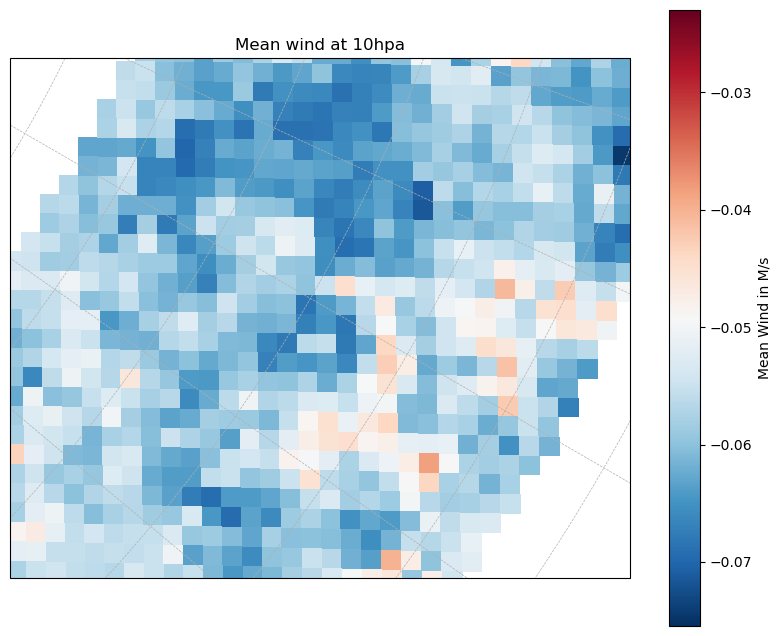

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

data = np.load('processed_airs_sftp/40_km_grid/30km/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.coastlines(resolution='10m', linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='--')

ax.set_extent([55, 65, 55, 65], crs=ccrs.PlateCarree()) # New extent

plt.pcolormesh(grid.nh_lon, grid.nh_lat, data, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())

plt.colorbar(label='Mean Wind in M/s')

plt.title(f'Mean wind at 10hpa')


plt.show()

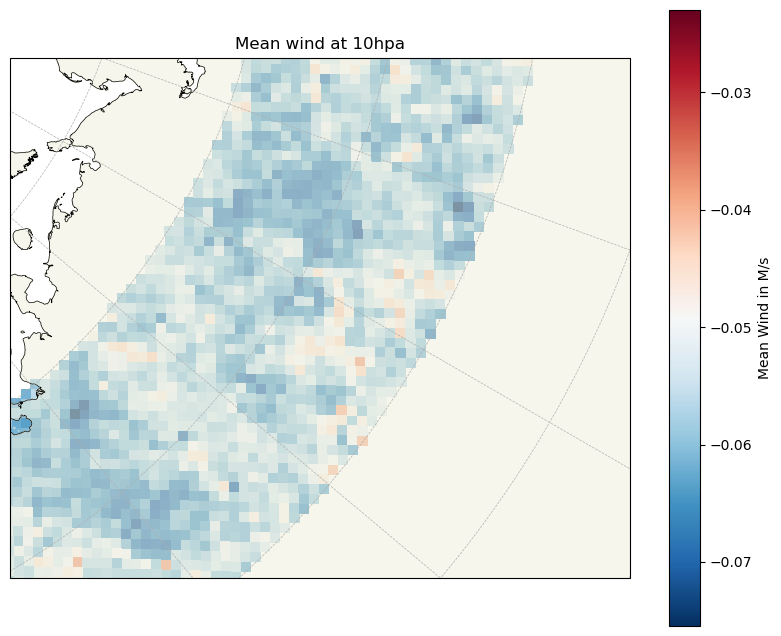

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

# Load data
data = np.load('processed_airs_sftp/40_km_grid/30km/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()
stamen_terrain = cimgt.Stamen('terrain-background')


# Set up figure and projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([50, 70, 50, 70], crs=ccrs.PlateCarree())

# Add background image of terrain/altitude contours
raster = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land'])
ax.add_feature(raster, alpha=0.5)

# Add coastline and gridlines
ax.coastlines(resolution='10m', linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='--')

# Add data layer
plt.pcolormesh(grid.nh_lon, grid.nh_lat, data, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(label='Mean Wind in M/s')
plt.title(f'Mean wind at 10hpa')

plt.show()


<h1>Main Momentum Flux Calculations</h1>

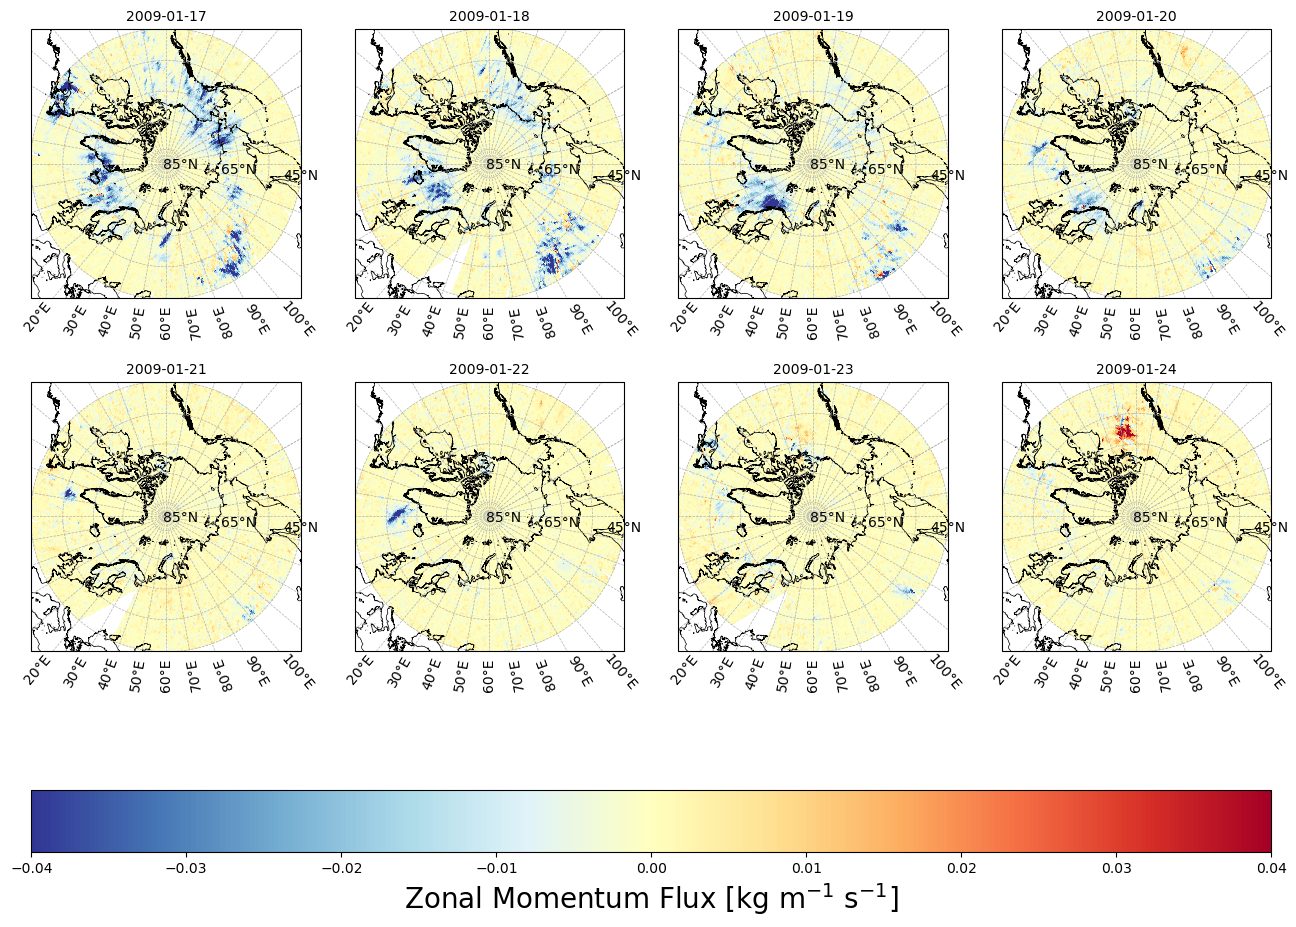

In [30]:
# =================================================================================================
# Plot on contous  (mfx and perturbations)
# =================================================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Load data
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()


data_type = 'mfx'
days = 8
dates = get_day_array(date_string="2009-01-25",days=days)
data_dict = {}

for i in range(days):
    data = np.load(f'processed_airs_sftp/40_km_grid/30km/{data_type}/{dates[i]}_{data_type}.npz')['arr_0']
    data_climatological_mean = np.load(f'climatology/airs/30km/{data_type}/{dates[i][5:]}_daily_average.npz')['arr_0']
    perturbation = data - data_climatological_mean
    data_dict[f"data_{i+1}"] = data

grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

# Create figure with two subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=60)})

# Flatten the 2D array of subplots into a 1D array
axs = axs.ravel()
levels = 7

min_value = min([np.nanmin(data_dict[f'data_{i}']) for i in range(1, days + 1)])
max_value = max([np.nanmax(data_dict[f'data_{i}']) for i in range(1, days + 1)])

vmin = -0.04
vmax = 0.04
data_i = 1

# Loop over subplots and plot data
for i, ax in enumerate(axs):
    # Set extent for subplot
    ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
    data = data_dict[f'data_{data_i}']
    # Plot data as contours
    ax.coastlines(resolution='10m', linewidth=0.5)
    
    gl = ax.gridlines(linewidth=0.5, linestyle='--', draw_labels=True)
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = plt.FixedLocator(np.arange(45, 91, 10))
    gl.top_labels = False
    gl.left_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.pcolormesh(grid.nh_lon, grid.nh_lat, data, vmin=vmin, vmax=vmax, cmap='RdYlBu_r', transform=ccrs.PlateCarree())

    # ax.contourf(grid.nh_lon, grid.nh_lat, data, levels=levels, vmin=vmin, vmax=vmax, cmap='rainbow', transform=ccrs.PlateCarree())
    ax.set_title(dates[data_i-1], fontsize=10)  # Decrease the fontsize
    # Increment i
    data_i += 1

# Adjust space between subplots
fig.subplots_adjust(wspace=0.20, hspace=0.20)

# Add a colorbar to the figure and put it to the right side of the subplots
# cbar = fig.colorbar(axs[-1].contourf(grid.nh_lon, grid.nh_lat, data, levels=levels, vmin=vmin, vmax=vmax, cmap='rainbow', transform=ccrs.PlateCarree()),
#                     ax=axs.tolist(),
#                     location='bottom',
#                     aspect=20)

cbar = fig.colorbar(axs[-1].pcolormesh(grid.nh_lon, grid.nh_lat, data, vmin=vmin, vmax=vmax, cmap='RdYlBu_r', transform=ccrs.PlateCarree()),
                    ax=axs.tolist(),
                    location='bottom',
                    aspect=20)

cbar.set_label('Zonal Momentum Flux [kg m$^{-1}$ s$^{-1}$]', fontsize=20)  # Increase the fontsize

# Show the plot
plt.show()


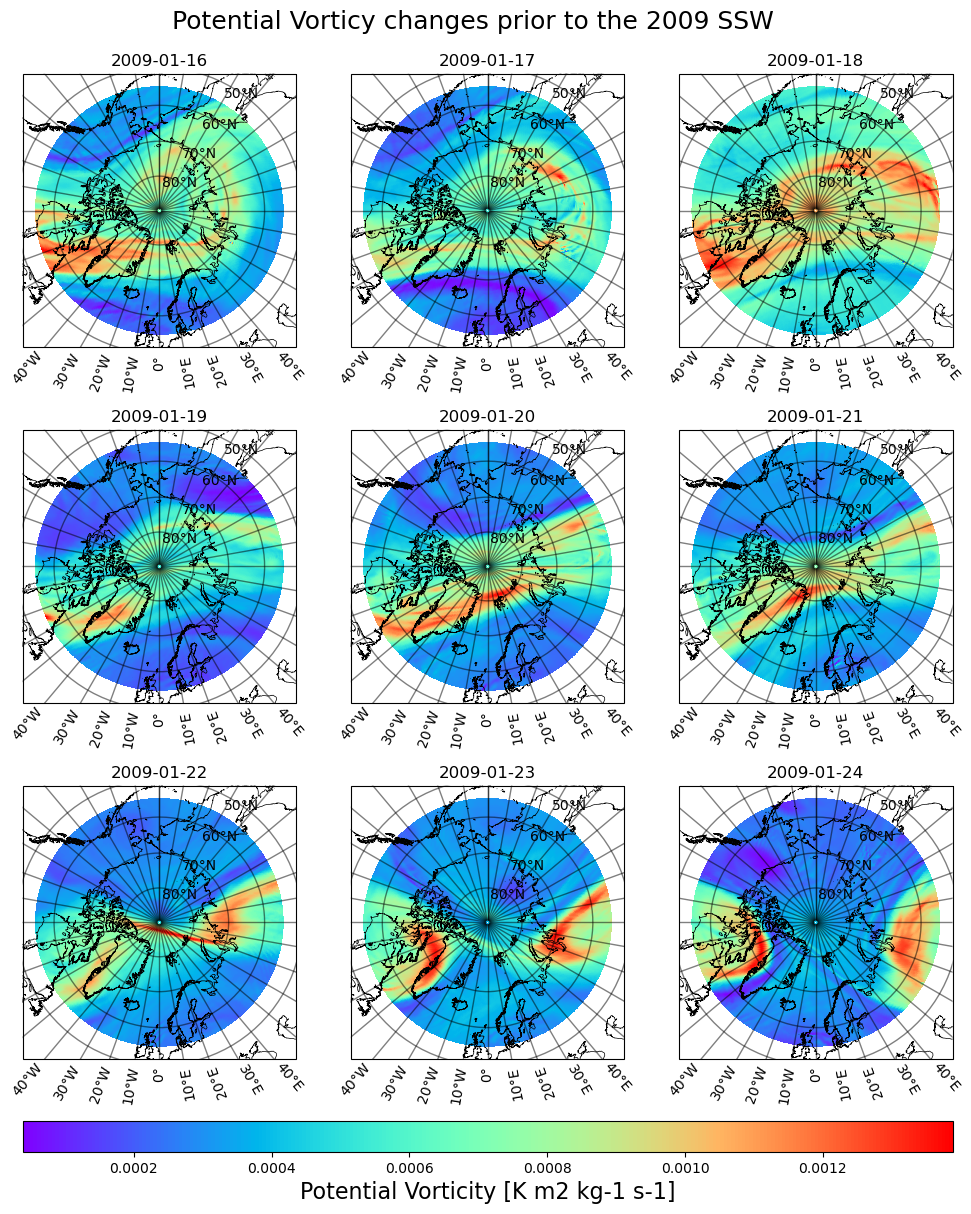

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

days = 9
dates = get_day_array(date_string="2009-01-26",days=days)

grid = map_grid(grid_size=None, source='era5_online')

def plot_wind_data(dates, grid):
    fig, axs = plt.subplots(3, 3, figsize=(12, 16), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    axs = axs.ravel()

    for i, ax in enumerate(axs):
        data = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/POTENTIAL_VORTICITY/{dates[i]}.npz')['arr_0']
        ax.coastlines(resolution='10m', linewidth=0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0.5, linestyle='-')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
        gl.ylocator = plt.FixedLocator(np.arange(50, 91, 10))

        gl.top_labels = False
        gl.left_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # ax.contourf(grid.grid_[0], grid.grid_[1], data, levels=8, cmap='rainbow', transform=ccrs.PlateCarree())
        ax.pcolormesh(grid.grid_[0], grid.grid_[1], data, cmap='rainbow', transform=ccrs.PlateCarree())

        ax.set_title(dates[i])

    fig.subplots_adjust(wspace=0.20, hspace=0.30)
    fig.suptitle('Potential Vorticy changes prior to the 2009 SSW', fontsize=18, y=0.92)

    # cbar = fig.colorbar(axs[-1].contourf(grid.grid_[0], grid.grid_[1], data, levels=8, cmap='rainbow', 
    #         transform=ccrs.PlateCarree()),
    #         ax=axs.tolist(), 
    #         location='bottom',
    #         aspect= 30,
    #         pad=0.05)

    cbar = fig.colorbar(axs[-1].pcolormesh(grid.grid_[0], grid.grid_[1], data, cmap='rainbow', 
            transform=ccrs.PlateCarree()),
            ax=axs.tolist(), 
            location='bottom',
            aspect= 30,
            pad=0.05)

    cbar.set_label('Potential Vorticity [K m2 kg-1 s-1]', fontsize=16)
    plt.show()

dates = get_day_array(date_string="2009-01-25", days=9)
grid = map_grid(grid_size=None, source='era5_online')
plot_wind_data(dates, grid)
